In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.uncertainty import plot_beta_loss

import yaml
import wandb

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'uncer.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

In [9]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

# m2_params = copy.deepcopy(config['fitting'])
# m2_params['split']['val_period'] = 0
# predictions_dict['m2'] = single_fitting_cycle(**m2_params)

# predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_25112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 172                 | 173                 | 174                 | 175                 | 176                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-15 00:00:00 | 2020-10-16 00:00:00 | 2020-10-17 00:00:00 | 2020-10-18 00:00:00 | 2020-10-19 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 236513.43           | 238242.43           | 240335.0            | 241935.0            | 243169.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.4265811359946157,
 'I_hosp_ratio': 0.30968209064545693,
 'P_fatal': 0.027805662548732245,
 'T_inc': 4.113864534136392,
 'T_inf': 3.9601423309654935,
 'T_recov': 11.379713997285657,
 'T_recov_fatal': 18.957810589073826,
 'lockdown_R0': 0.7469655380540087}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.30320628999453186,
 'I_hosp_ratio': 0.33261095792649775,
 'P_fatal': 0.04770621618746472,
 'T_inc': 4.123831144393644,
 'T_inf': 3.757706527596756,
 'T_recov': 9.798215258659514,
 'T_recov_fatal': 33.80395547544287,
 'lockdown_R0': 0.7582092560201121}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

,train,val
total,0.357297,0.92626
active,2.62897,4.48177
recovered,0.606989,1.30655
deceased,0.124978,0.0526919


### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

,train
total,0.13138
active,2.68053
recovered,0.272857
deceased,0.256889


## Sensitivity Plot

100%|██████████| 101/101 [00:01<00:00, 93.70it/s]


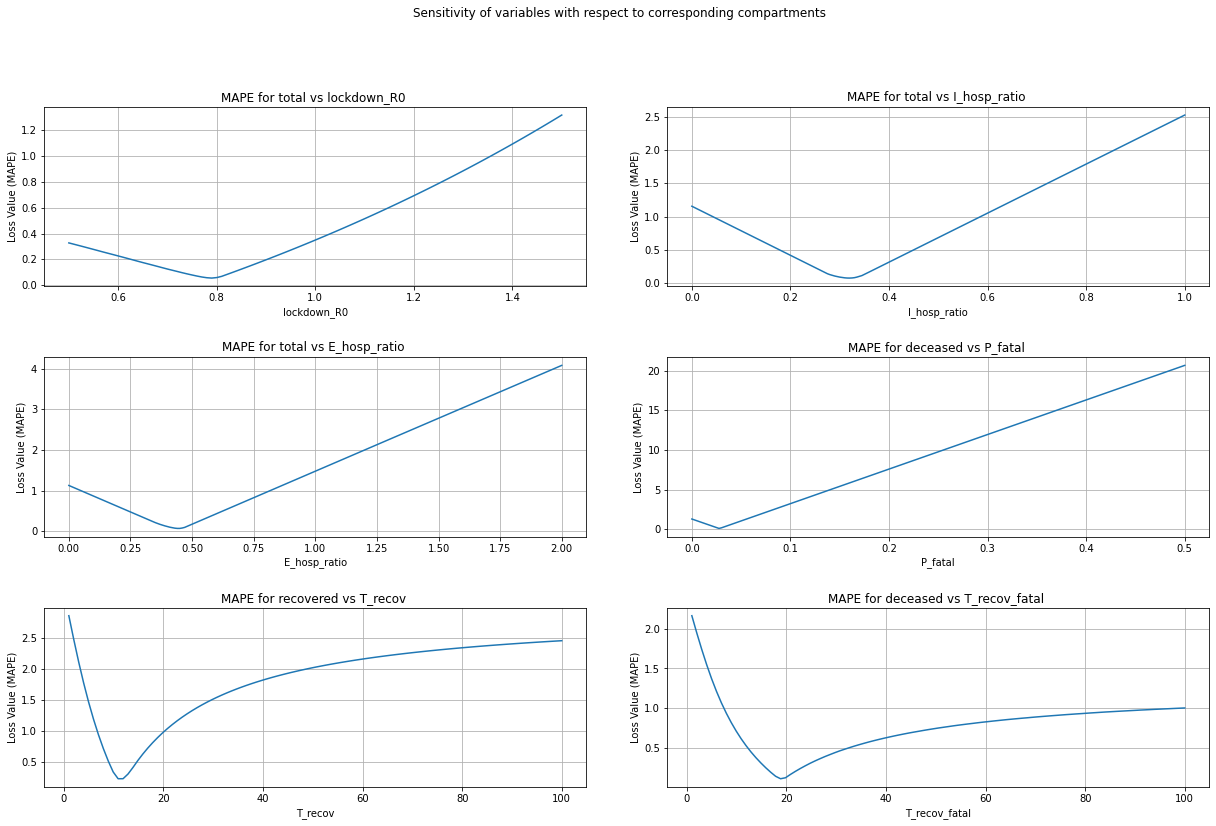

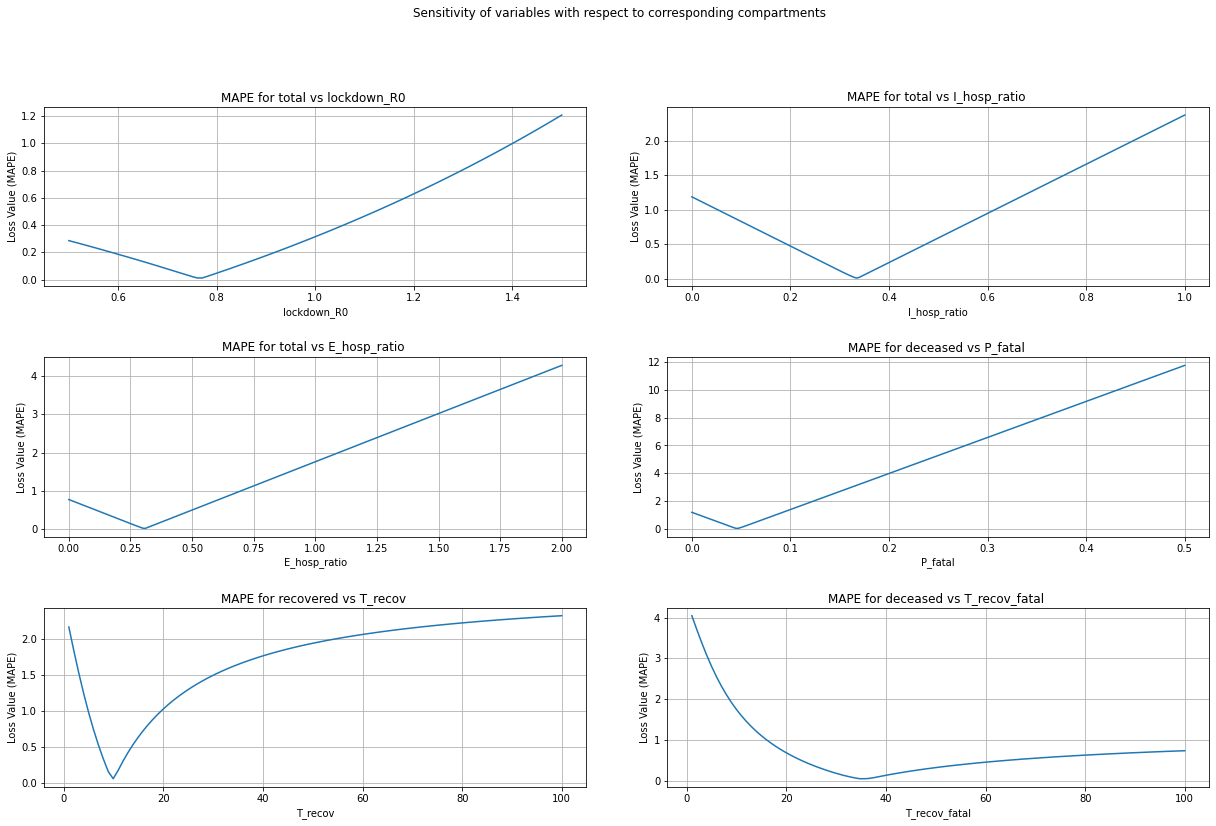

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

# Plot Best Forecast

getting forecasts ..
getting forecasts ..


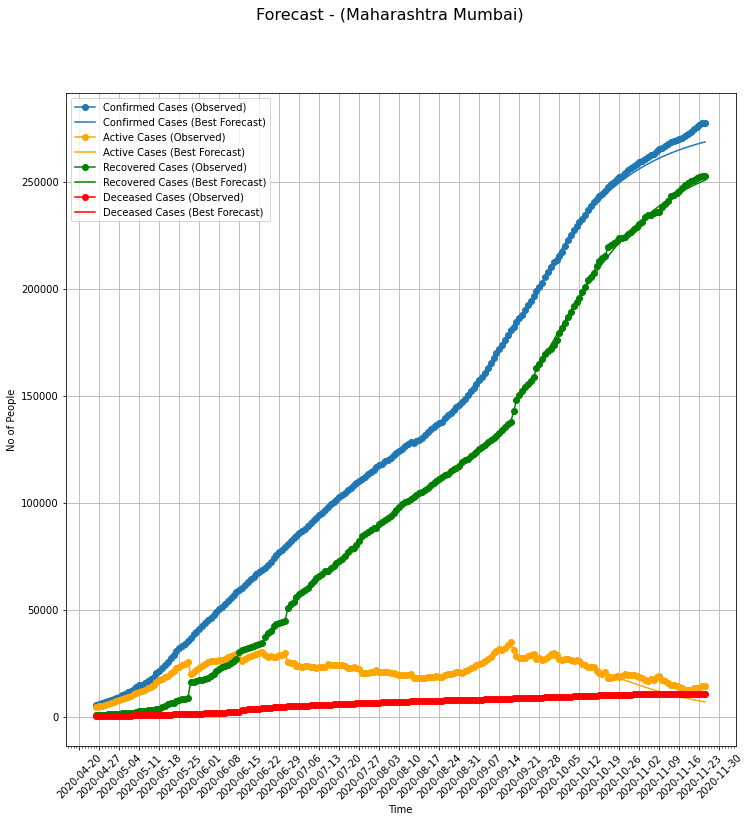

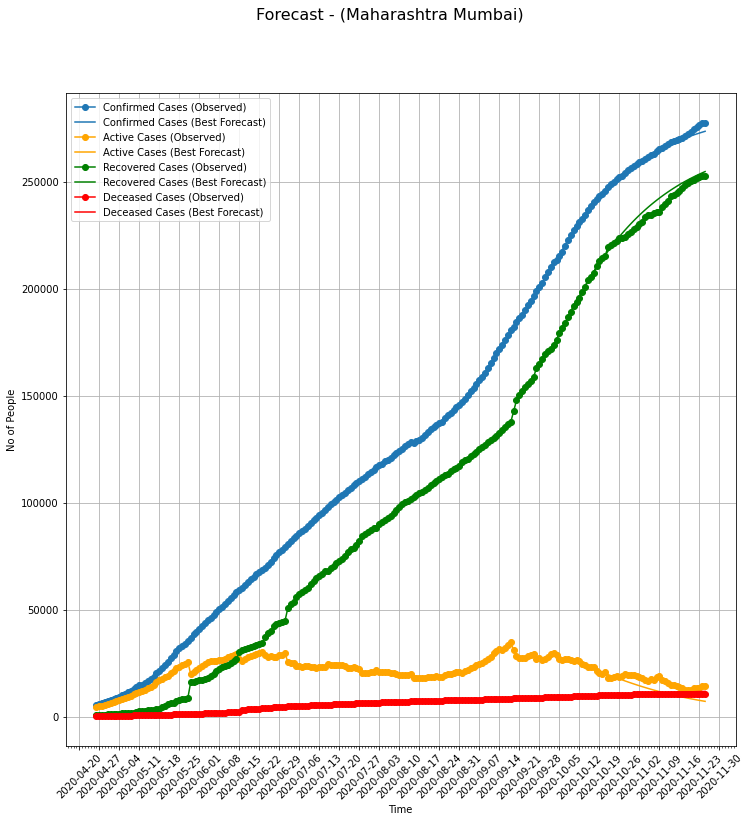

In [12]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m1']['forecasts'] = {}
for fit in ['m1', 'm2']:
    predictions_dict[fit]['forecasts']['best'] = get_forecast(predictions_dict, train_fit=fit, 
                                                              model=config['fitting']['model'], 
                                                              train_end_date=config['fitting']['split']['end_date'],
                                                              forecast_days=config['forecast']['forecast_days'])

    predictions_dict[fit]['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                    config['fitting']['data']['dataloading_params']['location_description'],
                                                                    which_fit=fit,
                                                                    which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                    error_bars=False)

## Process trials + Find best beta

In [14]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)


0it [00:00, ?it/s]
14it [00:00, 132.15it/s]

getting forecasts ..



29it [00:00, 135.27it/s]
44it [00:00, 138.42it/s]
59it [00:00, 141.27it/s]
74it [00:00, 143.08it/s]
89it [00:00, 144.03it/s]
104it [00:00, 145.29it/s]
119it [00:00, 144.25it/s]
134it [00:00, 145.08it/s]
150it [00:01, 146.57it/s]
165it [00:01, 141.85it/s]
179it [00:01, 140.45it/s]
193it [00:01, 139.83it/s]
207it [00:01, 138.14it/s]
221it [00:01, 136.83it/s]
235it [00:01, 135.31it/s]
250it [00:01, 137.96it/s]
265it [00:01, 139.95it/s]
280it [00:01, 141.79it/s]
296it [00:02, 144.57it/s]
311it [00:02, 144.74it/s]
326it [00:02, 144.62it/s]
341it [00:02, 140.08it/s]
356it [00:02, 139.04it/s]
371it [00:02, 140.96it/s]
386it [00:02, 143.11it/s]
401it [00:02, 143.20it/s]
416it [00:02, 144.67it/s]
432it [00:03, 146.49it/s]
447it [00:03, 147.00it/s]
462it [00:03, 147.15it/s]
477it [00:03, 147.83it/s]
492it [00:03, 148.23it/s]
507it [00:03, 148.47it/s]
522it [00:03, 147.56it/s]
537it [00:03, 147.89it/s]
553it [00:03, 149.45it/s]
568it [00:03, 146.52it/s]
584it [00:04, 147.57it/s]
599it [00:04, 13

getting forecasts ..



31it [00:00, 147.89it/s]
46it [00:00, 145.94it/s]
59it [00:00, 140.18it/s]
72it [00:00, 136.17it/s]
85it [00:00, 133.18it/s]
100it [00:00, 135.77it/s]
115it [00:00, 139.20it/s]
130it [00:00, 141.32it/s]
145it [00:01, 143.75it/s]
160it [00:01, 145.28it/s]
175it [00:01, 146.37it/s]
190it [00:01, 146.67it/s]
205it [00:01, 147.32it/s]
220it [00:01, 146.24it/s]
235it [00:01, 145.60it/s]
250it [00:01, 146.56it/s]
265it [00:01, 146.45it/s]
280it [00:01, 144.53it/s]
295it [00:02, 145.81it/s]
311it [00:02, 147.79it/s]
326it [00:02, 147.00it/s]
341it [00:02, 146.66it/s]
356it [00:02, 146.76it/s]
371it [00:02, 144.28it/s]
386it [00:02, 145.81it/s]
401it [00:02, 146.77it/s]
416it [00:02, 146.64it/s]
431it [00:02, 147.37it/s]
446it [00:03, 147.24it/s]
462it [00:03, 148.59it/s]
477it [00:03, 147.45it/s]
492it [00:03, 147.98it/s]
507it [00:03, 147.97it/s]
522it [00:03, 146.96it/s]
538it [00:03, 148.76it/s]
553it [00:03, 146.06it/s]
568it [00:03, 145.71it/s]
584it [00:04, 147.63it/s]
599it [00:04, 14

Best beta - 10.0
Min Loss - 1.8588118540087015


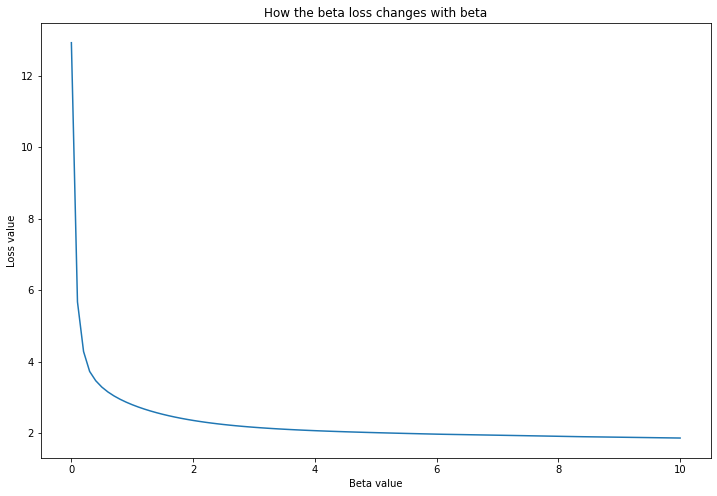

In [15]:
predictions_dict['m2']['plots']['beta_loss'], _ = plot_beta_loss(uncertainty.dict_of_trials)

In [20]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

## Plot Top k Trials

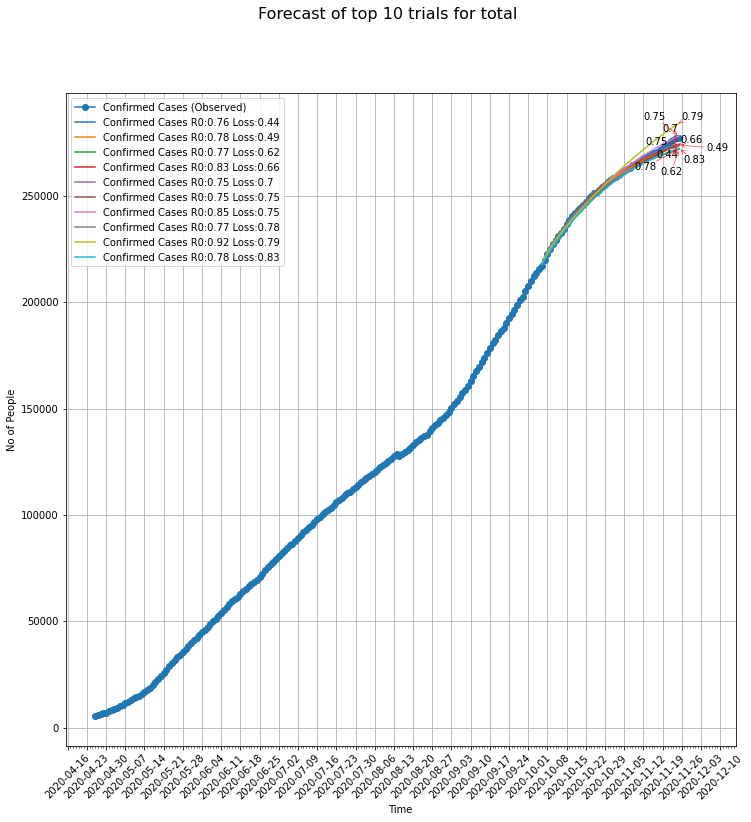

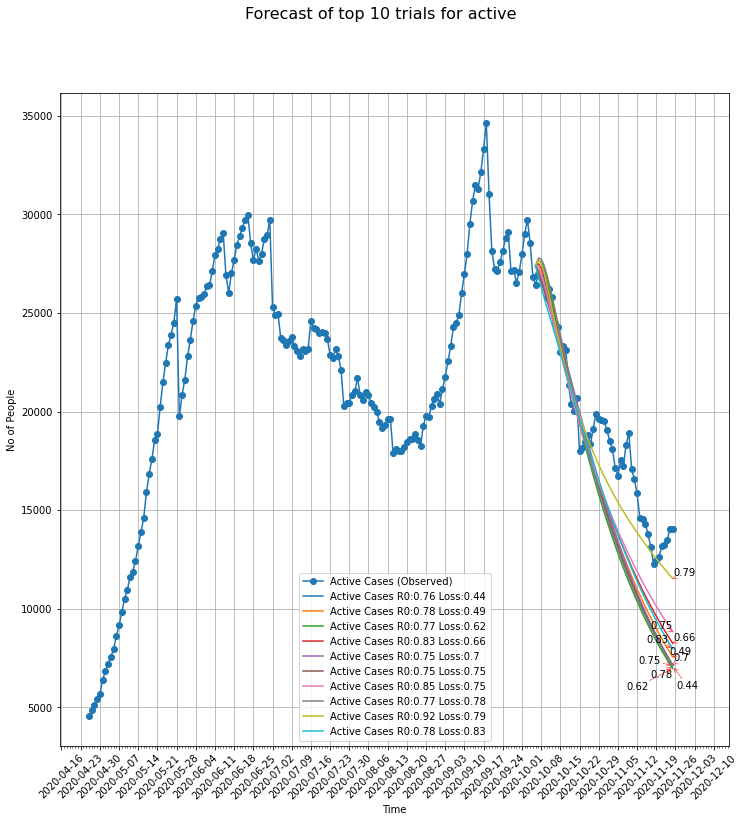

In [21]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

In [22]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

## Plot Deciles Forecasts

In [23]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    config['fitting']['data']['dataloading_params']['location_description'],
                                                                    which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    config['fitting']['data']['dataloading_params']['location_description'],
                                                                    which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             config['fitting']['data']['dataloading_params']['location_description'],
                                                                             which_compartments=config['fitting']['loss']['loss_compartments'],
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

KeyError: 50

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')